In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries 📚⬇

In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import torchvision.transforms as T
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torch.utils import data
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from skimage import io
from skimage import color
from skimage import transform
from skimage import util

In [3]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

### Defining train / val / test directories 📁

In [4]:
opt_dict = {
    'n_epochs': 200, 
    'batch_size': 4, 
    'lr': 5e-05, 
    'n_cpu': 8, 
    'latent_dim': 100, 
    'img_size': 224, 
    'channels': 4, 
    'n_critic': 5, 
    'clip_value': 0.01, 
    'sample_interval': 10
    }

class AttDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttDict, self).__init__(*args, **kwargs)
        self.__dict__=self

arg = AttDict(opt_dict)

In [5]:
DATA_DIR = '/content/drive/MyDrive/BTPII'

# x_train_dir = os.path.join(DATA_DIR, 'train')
# y_train_dir = os.path.join(DATA_DIR, 'train_labels')

# x_valid_dir = os.path.join(DATA_DIR, 'val')
# y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

# x_test_dir = os.path.join(DATA_DIR, 'test')
# y_test_dir = os.path.join(DATA_DIR, 'test_labels')

#### Shortlist specific classes to segment

### Helper functions for viz. & one-hot encoding/decoding

In [6]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [7]:
cuda = True if torch.cuda.is_available() else False
Tensor =  torch.FloatTensor

#### Fake Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_size, channels):

        super(Generator, self).__init__()
         # in: latent_size x 1 x 1

        self.gen = generator = nn.Sequential(

            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Conv2d(8, channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )

    def forward(self, z):
        img = self.gen(z)
        return img


In [9]:
generator_fake = Generator(latent_size = 100, channels = 4)
generator_fake.load_state_dict(torch.load("/content/drive/MyDrive/BTPII/checkpoint/dcgan.pth", map_location=torch.device('cpu'))['generator'])
generator_fake.eval()

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(3

#### Dataset

In [10]:
## data loader
class ListDataset(data.Dataset):

    def __init__(self, dataset, mode, crop_size, generator, normalization='minmax', hidden_classes=None, overlap=False, use_dsm=False):

        # Initializing variables.
        self.root = os.path.join(DATA_DIR, dataset)
        self.dataset = dataset
        self.mode = mode
        self.crop_size = crop_size
        self.normalization = normalization
        self.hidden_classes = hidden_classes
        self.overlap = overlap
        self.use_dsm = use_dsm
        
        self.num_classes = 5 # For Vaihingen and Potsdam.
            
        if self.hidden_classes is not None:
            self.n_classes = self.num_classes - len(hidden_classes)
        else:
            self.n_classes = self.num_classes

        self.generator = generator
        self.generator.eval()
        # Creating list of paths.
        self.imgs = self.make_dataset()

        # Check for consistency in list.
        if len(self.imgs) == 0:

            raise (RuntimeError('Found 0 images, please check the data set'))

        

    def make_dataset(self):

        # Making sure the mode is correct.
        assert self.mode in ['Train', 'Test', 'Val']

        # Setting string for the mode.
        img_dir = os.path.join(self.root, self.mode, 'Images')
        msk_dir = os.path.join(self.root, self.mode, 'Masks')
        if self.use_dsm:
            dsm_dir = os.path.join(self.root, self.mode, 'NDSM')

        # if self.mode == 'Val':
        #     img_dir = os.path.join(self.root, 'Train', 'Images')
        #     msk_dir = os.path.join(self.root, 'Train', 'Masks')
        #     if self.use_dsm:
        #         dsm_dir = os.path.join(self.root, 'Train', 'NDSM')

        data_list = sorted([f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))])

        # Creating list containing image and ground truth paths.
        items = []
        if self.dataset == 'Vaihingen':
            for it in data_list:
                item = (
                    os.path.join(img_dir, it),
                    os.path.join(msk_dir, it),
                    # os.path.join(dsm_dir, it.replace('top_mosaic_09cm_area', 'dsm_09cm_matching_area').replace('.tif', '_normalized.jpg'))
                )
                items.append(item)
        elif self.dataset == 'Potsdam':
            for it in data_list:
                if self.use_dsm:
                    item = (
                        os.path.join(img_dir, it),
                        os.path.join(msk_dir, it.replace('_IRRG.tif', '_label.tif')),
                        # os.path.join(msk_dir, it.replace('_IRRG.tif', '_label_noBoundary.tif')),
                        os.path.join(dsm_dir, it.replace('top_potsdam_', 'dsm_potsdam_').replace('_IRRG.tif', '_normalized_lastools.jpg'))
                    )
                else:
                    item = (
                        os.path.join(img_dir, it),
                        os.path.join(msk_dir, it.replace('_IRRG.tif', '_label.tif')),
                        # os.path.join(msk_dir, it.replace('_IRRG.tif', '_label_noBoundary.tif')),
                        # os.path.join(dsm_dir, it.replace('top_potsdam_', 'dsm_potsdam_').replace('_IRRG.tif', '_normalized_lastools.jpg'))
                    )
                items.append(item)
        
        # Returning list.
        return items
    
    def random_crops(self, img, msk, msk_true, n_crops):
        
        img_crop_list = []
        msk_crop_list = []
        msk_true_crop_list = []
        
        rand_fliplr = np.random.random() > 0.50
        rand_flipud = np.random.random() > 0.50
        rand_rotate = np.random.random()
        
        for i in range(n_crops):
            
            rand_y = np.random.randint(msk.shape[0] - self.crop_size[0])
            rand_x = np.random.randint(msk.shape[1] - self.crop_size[1])

            img_patch = img[rand_y:(rand_y + self.crop_size[0]),
                            rand_x:(rand_x + self.crop_size[1])]
            msk_patch = msk[rand_y:(rand_y + self.crop_size[0]),
                            rand_x:(rand_x + self.crop_size[1])]
            msk_true_patch = msk_true[rand_y:(rand_y + self.crop_size[0]),
                                      rand_x:(rand_x + self.crop_size[1])]
            
            if rand_fliplr:
                img_patch = np.fliplr(img_patch)
                msk_patch = np.fliplr(msk_patch)
                msk_true_patch = np.fliplr(msk_true_patch)
            if rand_flipud:
                img_patch = np.flipud(img_patch)
                msk_patch = np.flipud(msk_patch)
                msk_true_patch = np.flipud(msk_true_patch)
            
            if rand_rotate < 0.25:
                img_patch = transform.rotate(img_patch, 270, order=1, preserve_range=True)
                msk_patch = transform.rotate(msk_patch, 270, order=0, preserve_range=True)
                msk_true_patch = transform.rotate(msk_true_patch, 270, order=0, preserve_range=True)
            elif rand_rotate < 0.50:
                img_patch = transform.rotate(img_patch, 180, order=1, preserve_range=True)
                msk_patch = transform.rotate(msk_patch, 180, order=0, preserve_range=True)
                msk_true_patch = transform.rotate(msk_true_patch, 180, order=0, preserve_range=True)
            elif rand_rotate < 0.75:
                img_patch = transform.rotate(img_patch, 90, order=1, preserve_range=True)
                msk_patch = transform.rotate(msk_patch, 90, order=0, preserve_range=True)
                msk_true_patch = transform.rotate(msk_true_patch, 90, order=0, preserve_range=True)
                
            img_patch = img_patch.astype(np.float32)
            msk_patch = msk_patch.astype(np.int64)
            msk_true_patch = msk_true_patch.astype(np.int64)
            
            img_crop_list.append(img_patch)
            msk_crop_list.append(msk_patch)
            msk_true_crop_list.append(msk_true_patch)
        
        img = np.asarray(img_crop_list)
        msk = np.asarray(msk_crop_list)
        msk_true = np.asarray(msk_true_crop_list)
        
        return img, msk, msk_true
        
    def test_crops(self, img, msk, msk_true):
        
        n_channels = 3
        if self.use_dsm:
            n_channels = 4
        if self.overlap:
            w_img = util.view_as_windows(img,
                                         (self.crop_size[0], self.crop_size[1], n_channels),
                                         (self.crop_size[0] // 2, self.crop_size[1] // 2, n_channels)).squeeze()
            w_msk = util.view_as_windows(msk,
                                         (self.crop_size[0], self.crop_size[1]),
                                         (self.crop_size[0] // 2, self.crop_size[1] // 2))
            w_msk_true = util.view_as_windows(msk_true,
                                              (self.crop_size[0], self.crop_size[1]),
                                              (self.crop_size[0] // 2, self.crop_size[1] // 2))
        else:
            w_img = util.view_as_blocks(img, (self.crop_size[0], self.crop_size[1], n_channels)).squeeze()
            w_msk = util.view_as_blocks(msk, (self.crop_size[0], self.crop_size[1]))
            w_msk_true = util.view_as_blocks(msk_true, (self.crop_size[0], self.crop_size[1]))
        
        return w_img, w_msk, w_msk_true
        
    def shift_labels(self, msk):
        
        msk_true = np.copy(msk)
        
        cont = 0
        for h_c in self.hidden_classes:
            
            msk[msk == h_c - cont] = 100
            for c in range(h_c - cont + 1, self.num_classes):
                msk[msk == c] = c - 1
                msk_true[msk_true == c] = c - 1
            cont = cont + 1
        
        msk_true[msk == 100] = self.num_classes - len(self.hidden_classes)
        msk[msk == 100] = self.num_classes
        
        return msk, msk_true
    
    def mask_to_class(self, msk):
    
        msk = msk.astype(np.int64)
        new = np.zeros((msk.shape[0], msk.shape[1]), dtype=np.int64)
        
        msk = msk // 255
        msk = msk * (1, 7, 49)
        msk = msk.sum(axis=2)

        new[msk == 1 + 7 + 49] = 0 # Street.
        new[msk ==         49] = 1 # Building.
        new[msk ==     7 + 49] = 2 # Grass.
        new[msk ==     7     ] = 3 # Tree.
        new[msk == 1 + 7     ] = 4 # Car.
        new[msk == 1         ] = 5 # Surfaces.
        new[msk == 0         ] = 6 # Boundaries.

        return new
        
    def __getitem__(self, index):
        
        # Reading items from list.
        if index%6 != 5:
            index = index//6
            if self.use_dsm:
                img_path, msk_path, dsm_path = self.imgs[index]
            else:
                img_path, msk_path = self.imgs[index]
            
            # Reading images.
            img_raw = io.imread(img_path)
            msk_raw = io.imread(msk_path)
            if self.use_dsm:
                dsm_raw = io.imread(dsm_path)
                
            if len(img_raw.shape) == 2:
                img_raw = color.gray2rgb(img_raw)
            
            if self.use_dsm:
                img = np.full((img_raw.shape[0] + self.crop_size[0] - (img_raw.shape[0] % self.crop_size[0]),
                            img_raw.shape[1] + self.crop_size[1] - (img_raw.shape[1] % self.crop_size[1]),
                            img_raw.shape[2] + 1),
                            fill_value=0.0,
                            dtype=np.float32)
            else:
                img = np.full((img_raw.shape[0] + self.crop_size[0] - (img_raw.shape[0] % self.crop_size[0]),
                            img_raw.shape[1] + self.crop_size[1] - (img_raw.shape[1] % self.crop_size[1]),
                            img_raw.shape[2]),
                            fill_value=0.0,
                            dtype=np.float32)
            
            msk = np.full((msk_raw.shape[0] + self.crop_size[0] - (msk_raw.shape[0] % self.crop_size[0]),
                        msk_raw.shape[1] + self.crop_size[1] - (msk_raw.shape[1] % self.crop_size[1]),
                        msk_raw.shape[2]),
                        fill_value=0,
                        dtype=np.int64)
            
            img[:img_raw.shape[0], :img_raw.shape[1], :img_raw.shape[2]] = img_raw
            if self.use_dsm:
                img[:dsm_raw.shape[0], :dsm_raw.shape[1], -1] = dsm_raw
            msk[:msk_raw.shape[0], :msk_raw.shape[1]] = msk_raw
            
            msk = self.mask_to_class(msk)
            
            msk, msk_true = self.shift_labels(msk)
            
            # Normalization.
            img = (img / 255)-0.5
            
            if self.mode == 'Train' or self.mode == 'Val' or self.mode == 'Test':
                
                img, msk, msk_true = self.random_crops(img, msk, msk_true, 1)
                
                img = np.transpose(img, (0, 3, 1, 2))
            
            elif self.mode == 'Val_1':
                
                img, msk, msk_true = self.test_crops(img, msk, msk_true)
                
                img = np.transpose(img, (0, 1, 4, 2, 3))
                msk = np.transpose(msk, (0, 1, 2, 3))
                msk_true = np.transpose(msk_true, (0, 1, 2, 3))

                # mini = np.random.randint(img.shape[0], size=10)
                mini_in = np.random.randint(img.shape[1], size=10)

                img = img[:10, mini_in, :, :, :]
                msk = msk[:10, mini_in, :, :]
                msk_true = msk_true[:10, mini_in, :, :]

            elif self.mode == 'Test_!':
                
                img, msk, msk_true = self.test_crops(img, msk, msk_true)

                img = np.transpose(img, (0, 1, 4, 2, 3))
                msk = np.transpose(msk, (0, 1, 2, 3))
                msk_true = np.transpose(msk_true, (0, 1, 2, 3))

                mini_in = np.random.randint(img.shape[1], size=10)

                img = img[:10, mini_in, :, :, :]
                msk = msk[:10, mini_in, :, :]
                msk_true = msk_true[:10, mini_in, :, :]
            
            msk[msk == self.num_classes + 1] = self.num_classes
            msk_true[msk_true == self.num_classes + 1] = self.num_classes

            # Splitting path.
            spl = img_path.split('/')

            # Turning to tensors.
            img = torch.from_numpy(img[0, :, :, :]).type(Tensor)
            msk = torch.from_numpy(msk[0, :, :]).type(Tensor)

        else :
            noise_vec = torch.randn(1, arg.latent_dim, 1, 1).type(Tensor)
            img = self.generator(noise_vec).detach().type(Tensor)[0, :, :, :]
            msk = 6*torch.ones((self.crop_size[0], self.crop_size[1])).type(Tensor)
        # Returning to iterator.
        return img, msk

    def __len__(self):

        return 6*len(self.imgs)

#### Visualize Sample Image and Mask 📈

In [11]:
img_shape = (arg.channels, arg.img_size, arg.img_size)

In [12]:
class_names = ['Street', 'Building', 'Grass', 'Tree', 'Car', 'Surfaces', 'Unknown']
select_classes = ['Street', 'Building', 'Grass', 'Tree', 'Car', 'Surfaces', 'Unknown']
class_rgb_values = [[255, 255, 255], [0, 0, 255], [0, 255, 255], [0, 255, 0], [255, 255, 0], [255, 0, 0], [255, 0, 255]]
# Get RGB values of required classes
select_class_indices = [class_names.index(cls) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['Street', 'Building', 'Grass', 'Tree', 'Car', 'Surfaces', 'Unknown']
Class RGB values:  [[255, 255, 255], [0, 0, 255], [0, 255, 255], [0, 255, 0], [255, 255, 0], [255, 0, 0], [255, 0, 255]]


In [13]:
# dataset = ListDataset('Potsdam', 'Train', (img_shape[1], img_shape[2]), generator_fake, normalization='minmax', hidden_classes=[], overlap=False, use_dsm=True)
# random_idx = random.randint(0, len(dataset)-1)
# image, mask = dataset[2]

# visualize(
#     original_image = (image[:3, :, :].permute(1, 2, 0).numpy()+1)/2,
#     ground_truth_mask = colour_code_segmentation(mask[:, :].numpy(), select_class_rgb_values),
#     one_hot_encoded_mask = mask[:, :].numpy()
# )

### Defining Augmentations 🙃

In [14]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

In [15]:
# augmented_dataset = ListDataset('Potsdam', 'Train', (img_shape[1], img_shape[2]), generator_fake, normalization='minmax', hidden_classes=[], overlap=False, use_dsm=True)

# random_idx = random.randint(0, len(augmented_dataset)-1)

# # Different augmentations on a random image/mask pair (256*256 crop)
# for i in range(3):
#     image, mask = augmented_dataset[random_idx]
#     visualize(
#         original_image = (image[:3, :, :].permute(1, 2, 0).numpy()+1)/2,
#         ground_truth_mask = colour_code_segmentation(mask[:, :].numpy(), select_class_rgb_values),
#         one_hot_encoded_mask = mask[:, :].numpy()
#     )

## Training UNet

<h3><center>UNet Model Architecture</center></h3>
<img src="https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="750" height="750"/>
<h4><center><a href="https://arxiv.org/abs/1505.04597">Image Courtesy: UNet [Ronneberger et al.]</a></center></h4>

### Model Definition

In [16]:
class PreActivateDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PreActivateDoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.double_conv(x)

class PreActivateResUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PreActivateResUpBlock, self).__init__()
        self.ch_avg = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.ch_avg = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
        self.double_conv = PreActivateDoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x) + self.ch_avg(x)

class PreActivateResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PreActivateResBlock, self).__init__()
        self.ch_avg = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))

        self.double_conv = PreActivateDoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        identity = self.ch_avg(x)
        out = self.double_conv(x)
        out = out + identity
        return self.down_sample(out), out
    
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = self.downsample(x)
        out = self.double_conv(x)
        out = self.relu(out + identity)
        return self.down_sample(out), out


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

In [17]:
# Adapted from https://github.com/galprz/brain-tumor-segmentation/blob/master/src/models.py
class DeepResUNet(nn.Module):
    def __init__(self, channels, out_classes):
        super(DeepResUNet, self).__init__()
        self.n_classes = 6
        self.down_conv1 = PreActivateResBlock(channels, 64)
        self.down_conv2 = PreActivateResBlock(64, 128)
        self.down_conv3 = PreActivateResBlock(128, 256)
        self.down_conv4 = PreActivateResBlock(256, 512)

        self.double_conv = PreActivateDoubleConv(512, 1024)

        self.up_conv4 = PreActivateResUpBlock(512 + 1024, 512)
        self.up_conv3 = PreActivateResUpBlock(256 + 512, 256)
        self.up_conv2 = PreActivateResUpBlock(128 + 256, 128)
        self.up_conv1 = PreActivateResUpBlock(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [18]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = DeepResUNet(channels =4, out_classes = 7)

# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Get Train / Val DataLoaders

In [19]:
# Get train and val dataset instances
train_dataset = ListDataset('Potsdam', 'Train', (img_shape[1], img_shape[2]), generator_fake, normalization='minmax', hidden_classes=[], overlap=False, use_dsm=True)

valid_dataset = ListDataset('Potsdam', 'Val', (img_shape[1], img_shape[2]), generator_fake, normalization='minmax', hidden_classes=[], overlap=False, use_dsm=True)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=1)

#### Set Hyperparams

In [20]:
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True, ignore_index=-1):
        super(CrossEntropyLoss2d, self).__init__()
        self.__name__ = 'multi_class_ce'
        self.nll_loss = nn.NLLLoss(weight, ignore_index=ignore_index, reduction='mean')
    
    def forward(self, inputs, targets):
    	#print(inputs.shape)
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        return self.nll_loss(F.log_softmax(inputs, dim = 1).type(Tensor), targets.type(torch.LongTensor))

In [21]:
class DiceLoss(nn.Module):
    def __init__(self, num_classes):
        super(DiceLoss, self).__init__()
        self.__name__ = 'dice_loss'
        self.num_classes = num_classes

    def forward(self, logits, true):
        probas = F.softmax(logits, dim=1)
        true = true.to(DEVICE)
        true = true.view(true.shape[0], 1, true.shape[1], true.shape[2])
        true = true.type(torch.LongTensor)
        eps = 1e-7
        true_1_hot = torch.eye(self.num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot = true_1_hot.type(torch.cuda.LongTensor)
        dims = (0,) + tuple(range(2, true.ndimension()))
        intersection = torch.sum(probas * true_1_hot, dims)
        cardinality = torch.sum(probas + true_1_hot, dims)
        dice_loss = (2. * intersection / (cardinality + eps)).mean()
        return (1 - dice_loss)

In [22]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = False

# Set num of epochs
EPOCHS = 20

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

smp.losses.constants.MULTICLASS_MODE
# define loss function
loss = DiceLoss(7)

# define metrics
metrics = [
           CrossEntropyLoss2d(),
    # smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('/content/drive/MyDrive/BTPII/best_model_openunet3.pth'):
    model = torch.load('/content/drive/MyDrive/BTPII/best_model_openunet3.pth', map_location=DEVICE)

In [23]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [24]:
print(DEVICE)

cuda


### Training UNet

In [25]:
%%time
model.train()
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score > valid_logs['multi_class_ce']:
            best_iou_score = valid_logs['multi_class_ce']
            torch.save(model, '/content/drive/MyDrive/BTPII/checkpoint/best_model_openunet3.pth')
            print('Model saved!')

CPU times: user 1.13 ms, sys: 0 ns, total: 1.13 ms
Wall time: 7.72 ms


In [26]:
# torch.save(model, '/content/drive/MyDrive/BTPII/checkpoint/best_model_openunet3_final.pth')

### Prediction on Test Data

In [27]:
if os.path.exists('/content/drive/MyDrive/BTPII/checkpoint/best_model_openunet3.pth'):
    best_model = torch.load('/content/drive/MyDrive/BTPII/checkpoint/best_model_openunet3.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

test_dataset = ListDataset('Potsdam', 'Test', (img_shape[1], img_shape[2]), generator_fake, normalization='minmax', hidden_classes=[], overlap=False, use_dsm=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Loaded UNet model from this run.


In [28]:
# load best saved model checkpoint from the current run
# if os.path.exists('./best_model.pth'):
#     best_model = torch.load('./best_model.pth', map_location=DEVICE)
#     print('Loaded UNet model from this run.')

# # load best saved model checkpoint from previous commit (if present)
# elif os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
#     best_model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)
#     print('Loaded UNet model from a previous commit.')

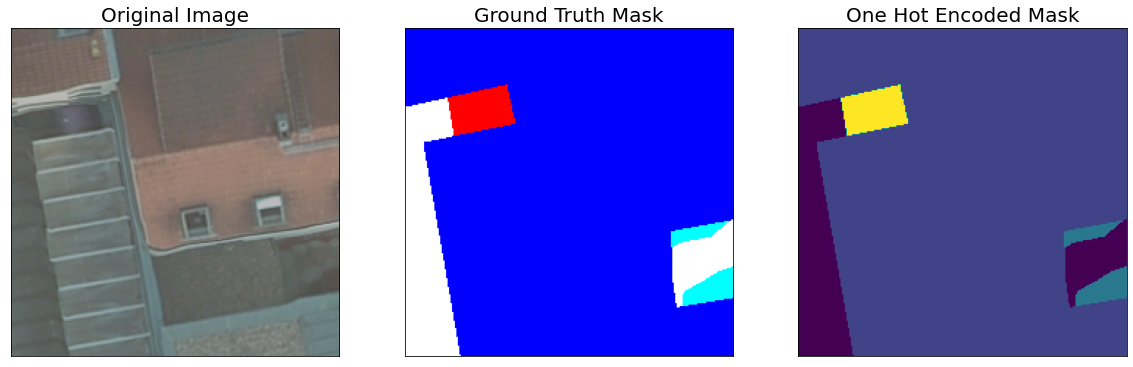

In [29]:
# # create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
# test_dataset = RoadsDataset(
#     x_test_dir, 
#     y_test_dir, 
#     augmentation=get_validation_augmentation(), 
#     preprocessing=get_preprocessing(preprocessing_fn),
#     class_rgb_values=select_class_rgb_values,
# )

# test_dataloader = DataLoader(test_dataset)

# # test dataset for visualization (without preprocessing transformations)
# test_dataset_vis = RoadsDataset(
#     x_test_dir, y_test_dir, 
#     augmentation=get_validation_augmentation(),
#     class_rgb_values=select_class_rgb_values,
# )

# # get a random test image/mask index
random_idx = random.randint(0, len(test_dataset)-1)
image, mask = test_dataset[random_idx]

visualize(
        original_image = (image[:3, :, :].permute(1, 2, 0).numpy()+1)/2,
        ground_truth_mask = colour_code_segmentation(mask[:, :].numpy(), select_class_rgb_values),
        one_hot_encoded_mask = mask[:, :].numpy()
    )
# visualize(
#     original_image = image,
#     ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
#     one_hot_encoded_mask = reverse_one_hot(mask)
# )

# # Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# # This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [30]:
image.shape

torch.Size([4, 224, 224])

In [31]:
# # Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [32]:
sample_preds_folder = '/content/drive/MyDrive/BTPII/sample_predictions_openset_gan2/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [33]:
class Plotter():
    def __init__(self):
        from matplotlib import colors
        '''
        Vaihingen/Potsdam classes:
            0 = Street
            1 = Building
            2 = Grass
            3 = Tree
            4 = Car
            5 = Surfaces
            6 = Unknown
        '''
        # no hidden class cmap
        cmap_list = [
            (1.0, 1.0, 1.0, 1.0), # street. 
            (0.0, 0.0, 1.0, 1.0), # Building
            (0.0, 1.0, 1.0, 1.0), # Grass.
            (0.0, 1.0, 0.0, 1.0), # Tree.
            (1.0, 1.0, 0.0, 1.0), # Car.
            (1.0, 0.0, 0.0, 1.0),  # surfaces
            (1.0, 0.0, 1.0, 1.0), # Unknown.
        ]
        self.lab_cmap = colors.ListedColormap(cmap_list)

    def plot(self, img, gt, pred, htmp, save, name=None):
        plt.figure(figsize=(20,8))
        plt.subplot(141)
        plt.title("Image")
        plt.imshow(img)
        plt.subplot(142)
        plt.title("Ground Truth")
        plt.imshow(gt, cmap=self.lab_cmap)
        plt.clim(0, 6)
        plt.subplot(143)
        plt.title("Prediction")
        plt.imshow(pred)
        plt.clim(0, 6)
        plt.subplot(144)
        plt.title("Unknown Heatmap")
        plt.imshow(htmp)
        if save:
            plt.savefig(name)
        else:
            plt.show()
        plt.clf()
        plt.close()

In [ ]:
plotter = Plotter()
for idx, (image, gt_mask) in enumerate(test_dataloader):
    # image, gt_mask = test_dataset[idx]
    x_tensor = image.to(DEVICE)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask[:, :, :],(1,2,0))
    # # Get prediction channel corresponding to road
    pred_unkn_heatmap = pred_mask[:,:,select_classes.index('Unknown')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = gt_mask[0, :, :]

    img_vis = (np.transpose(image[0, :3, :, :].numpy(), (1, 2, 0))+1)/2
    # cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([img_vis, gt_mask, pred_mask, pred_unkn_heatmap])[:,:,::-1])
    plotter.plot(img_vis, gt_mask, pred_mask, pred_unkn_heatmap, True, os.path.join(sample_preds_folder,"pred_{}.png".format(idx)))
    # visualize(
    #     original_image = img_vis,
    #     ground_truth_mask = gt_mask,
    #     predicted_mask = pred_mask,
    #     predicted_unknown_heatmap = pred_unkn_heatmap
    # )

In [ ]:
# image, gt_mask = next(iter(test_dataloader))
# x_tensor = image.to(DEVICE)
# # Predict test image
# pred_mask = best_model(x_tensor)
# pred_mask = pred_mask.detach().squeeze().cpu().numpy()
# # Convert pred_mask from `CHW` format to `HWC` format
# pred_mask = np.transpose(pred_mask[:, :, :],(1,2,0))
# # # Get prediction channel corresponding to road
# pred_unkn_heatmap = pred_mask[:,:,select_classes.index('Unknown')]
# pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
# # # Convert gt_mask from `CHW` format to `HWC` format
# gt_mask = gt_mask[0, :, :]

# img_vis = (np.transpose(image[0, :3, :, :].numpy(), (1, 2, 0))+1)/2

In [ ]:
# plotter = Plotter()

In [ ]:
# plotter.plot(img_vis, gt_mask, pred_mask, pred_unkn_heatmap, False)

In [34]:
metrics = [CrossEntropyLoss2d()]
loss = DiceLoss(7)

In [35]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['multi_class_ce']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 42/42 [05:22<00:00,  7.69s/it, dice_loss - 0.9318, multi_class_ce - 1.928]
Evaluation on Test Data: 
Mean IoU Score: 1.9278
Mean Dice Loss: 0.9318


In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['multi_class_ce']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 42/42 [04:42<00:00,  6.73s/it, dice_loss - 0.9344, multi_class_ce - 1.96]
Evaluation on Test Data: 
Mean IoU Score: 1.9601
Mean Dice Loss: 0.9344


### Plot Dice Loss & IoU Metric for Train vs. Val

In [ ]:
# train_logs_df = pd.DataFrame(train_logs_list)
# valid_logs_df = pd.DataFrame(valid_logs_list)
# train_logs_df.T

In [ ]:
# plt.figure(figsize=(20,8))
# plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
# plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
# plt.xlabel('Epochs', fontsize=21)
# plt.ylabel('IoU Score', fontsize=21)
# plt.title('IoU Score Plot', fontsize=21)
# plt.legend(loc='best', fontsize=16)
# plt.grid()
# plt.savefig('iou_score_plot.png')
# plt.show()

In [ ]:
# plt.figure(figsize=(20,8))
# plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
# plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
# plt.xlabel('Epochs', fontsize=21)
# plt.ylabel('Dice Loss', fontsize=21)
# plt.title('Dice Loss Plot', fontsize=21)
# plt.legend(loc='best', fontsize=16)
# plt.grid()
# plt.savefig('dice_loss_plot.png')
# plt.show()